In [33]:
%%capture
# Cat Meow Translator Notebook
# Purrceptron Labs (BETA)

# -*- coding: utf-8 -*-
"""
MEOW-to-English Translation System v0.1
(Warning: May contain 99% AI nonsense, 1% actual science)
"""

# ------------------
# 1. SETUP (Human, assemble my kibble!)
# ------------------
!pip install -q librosa matplotlib tensorflow kaggle pandas
!pip install --upgrade openai


import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

print("🐾 All systems purr! Let's decode some cat-titude.")
















In [34]:
from google.colab import userdata
# Retrieve the OpenAI API key from userdata (if stored)
openai_api_key = userdata.get('OPENAI_API_KEY')

# If not in userdata, prompt the user to enter it:
if openai_api_key is None:
  openai_api_key = input("Please enter your OpenAI API key: ")

# Set the environment variable
os.environ["OPENAI_API_KEY"] = openai_api_key


In [35]:
# ------------------
# 2. FETCH DATA (Where's my treats?!)
# ------------------
# Upload kaggle.json first!
from google.colab import files
files.upload()  # Upload your kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!# CORRECTED DOWNLOAD COMMAND
!kaggle datasets download -d andrewmvd/cat-meow-classification

!unzip -q cat-meow-classification.zip -d cat_meows

# Add this after unzipping
!ls cat_meows  # Check directory structure

print(" Dataset acquired. Containing:", len(os.listdir("cat_meows/dataset/dataset")), "meows of judgement.")

# print("🗃️ Dataset acquired. Containing:", len(os.listdir("cat_meows/dataset")), "meows of judgement.")

Saving kaggle.json to kaggle (2).json
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/cat-meow-classification
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
cat-meow-classification.zip: Skipping, found more recently modified local copy (use --force to force download)
replace cat_meows/dataset/dataset/B_ANI01_MC_FN_SIM01_101.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
dataset  extras
 Dataset acquired. Containing: 440 meows of judgement.


In [36]:
!find cat_meows -type d  # Debug directory structure

cat_meows
cat_meows/dataset
cat_meows/dataset/dataset
cat_meows/extras
cat_meows/extras/sequences
cat_meows/extras/other_vocalizations


In [45]:
# ------------------
# 3. DECODE FILENAMES (Cat cipher breaker)
# ------------------
def parse_cat_filename(filename):
    """Decrypts the feline Da Vinci Code"""
    parts = filename.split('_')
    return {
        'context': {'B': 'Brushing', 'F': 'Food Demand', 'I': 'Isolation'}[parts[0]],
        'cat_id': parts[1],
        'breed': 'Maine Coon' if parts[2] == 'MC' else 'European Shorthair',
        'sex': parts[3],
        'owner_id': parts[4],
        'session': parts[5][1:],
        'counter': parts[6].split('.')[0]
    }

# Example:
filename = "F_02345_MC_MN_67890_R3_15.wav"
print("🔍 File analysis:", parse_cat_filename(filename))

🔍 File analysis: {'context': 'Food Demand', 'cat_id': '02345', 'breed': 'Maine Coon', 'sex': 'MN', 'owner_id': '67890', 'session': '3', 'counter': '15'}


Trying directory: cat_meows/dataset/dataset
✓ Found 440 cat audio files in cat_meows/dataset/dataset


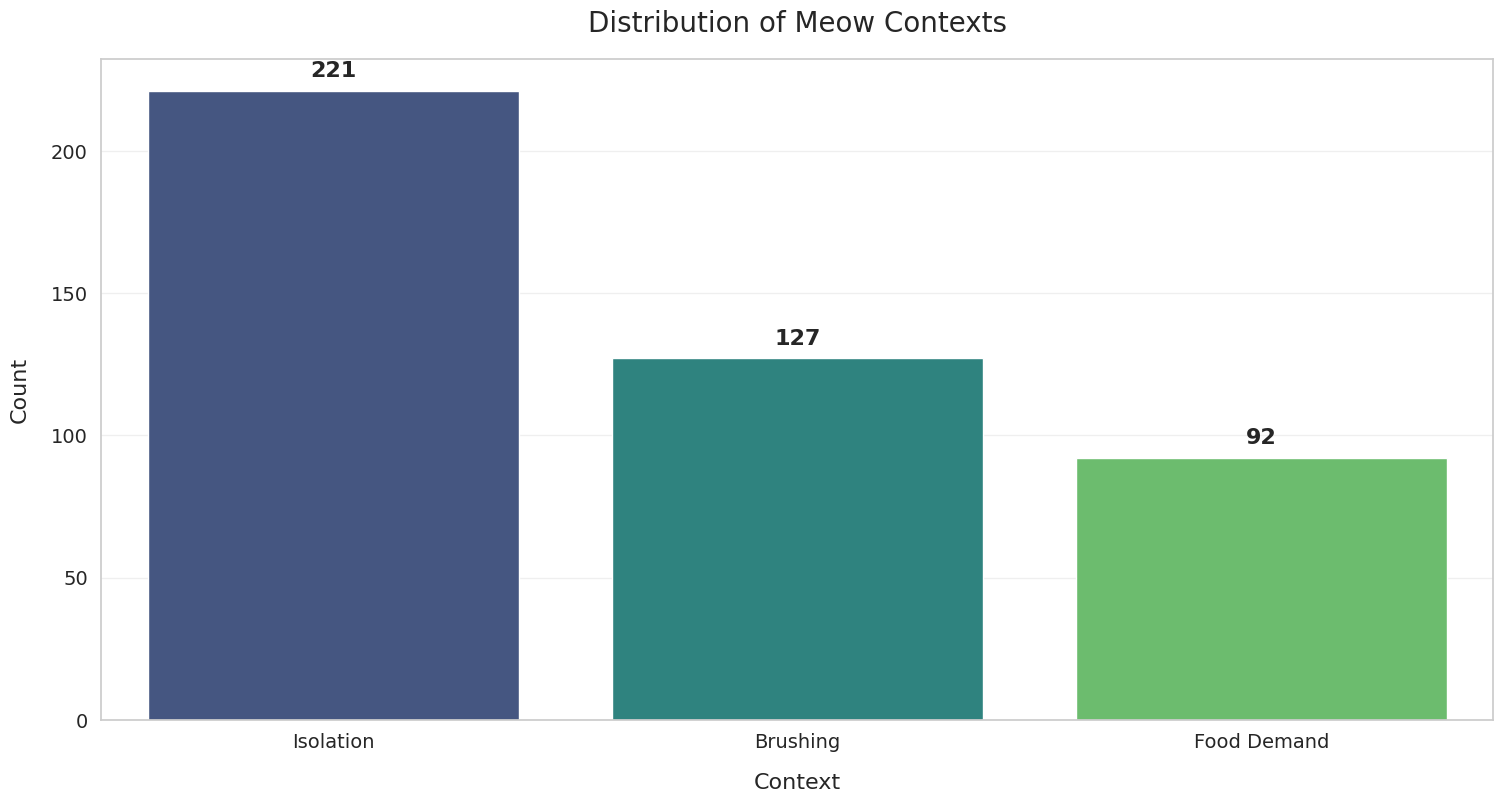

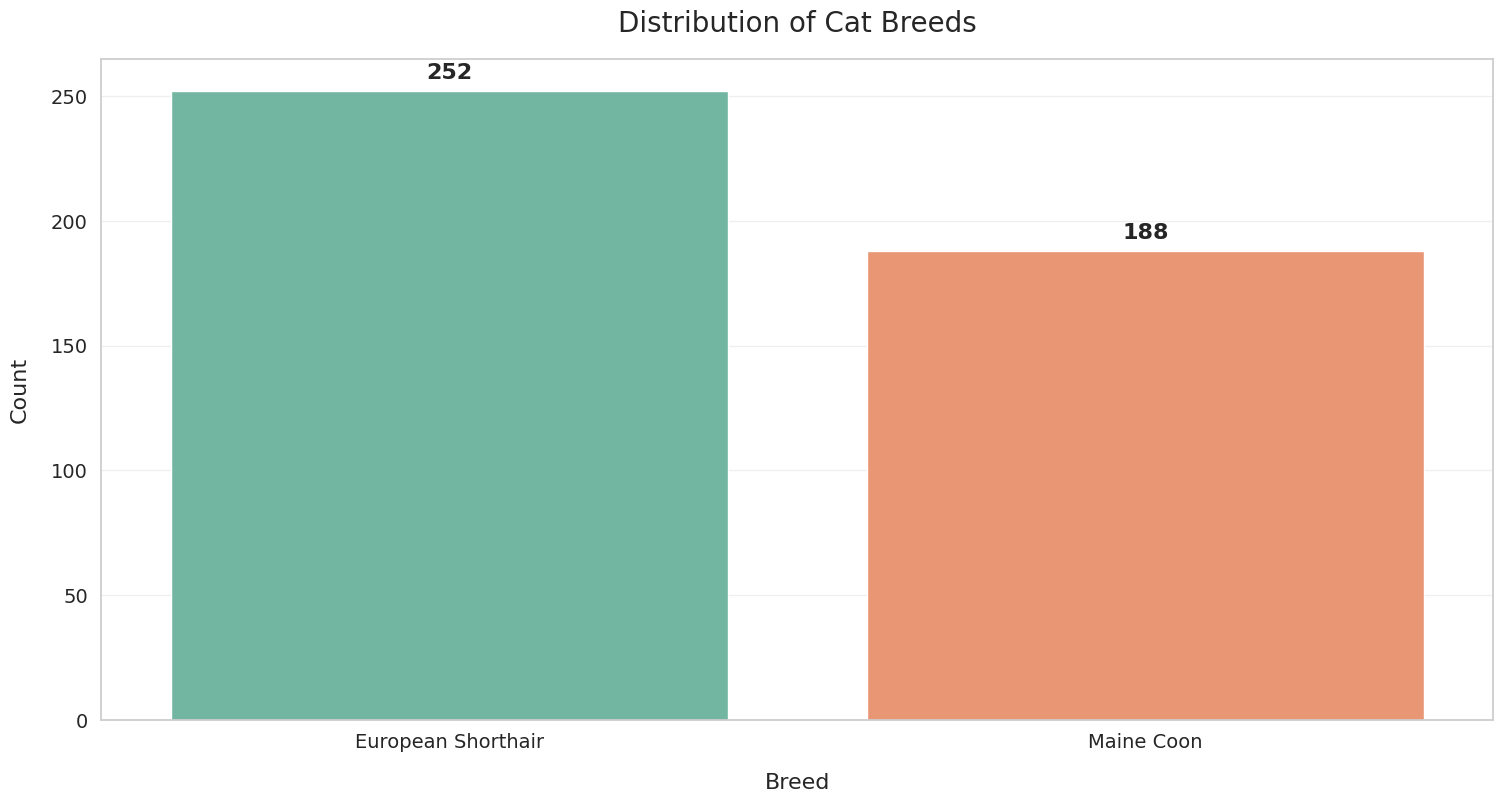

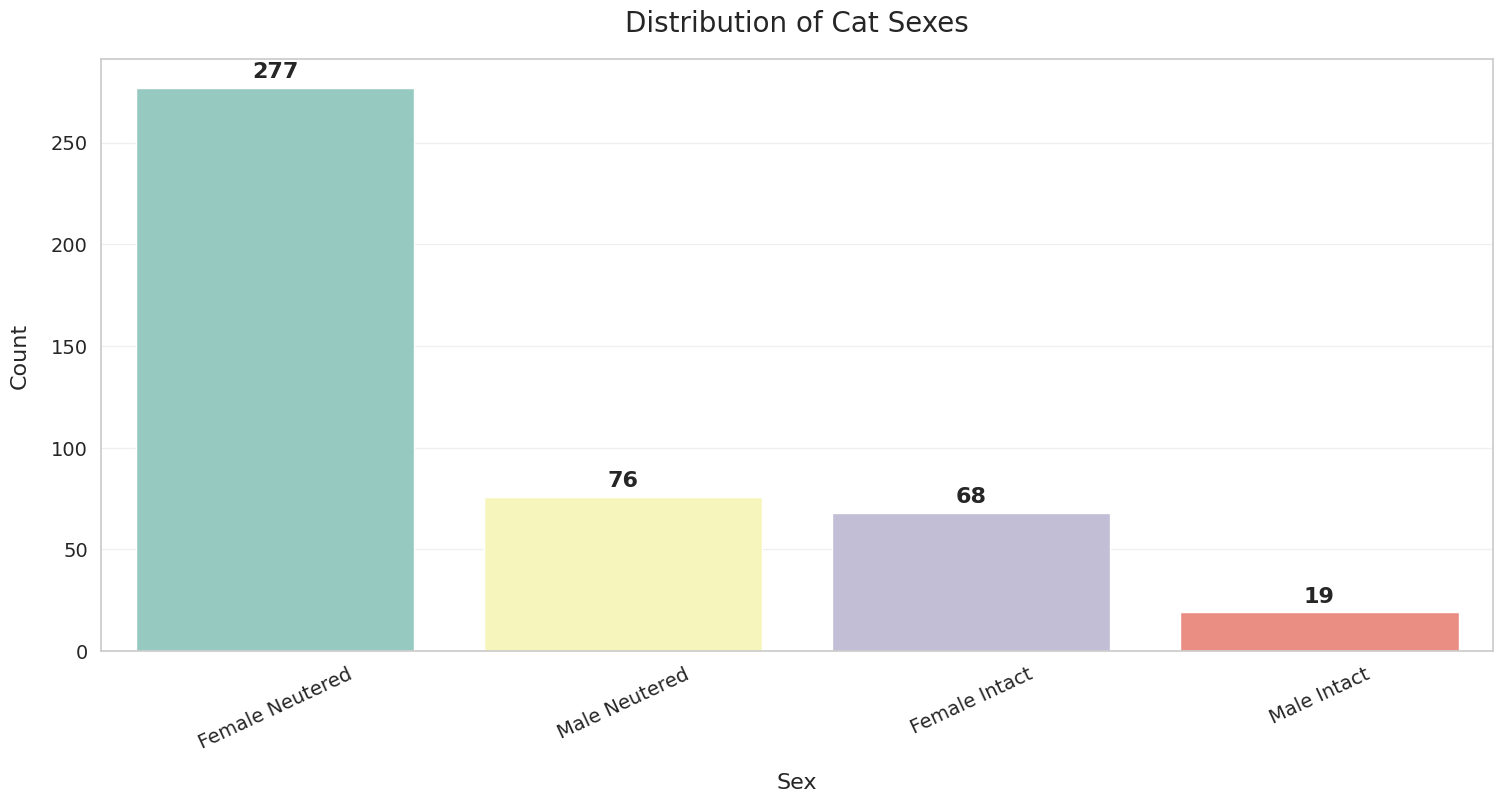

<Figure size 1600x900 with 0 Axes>

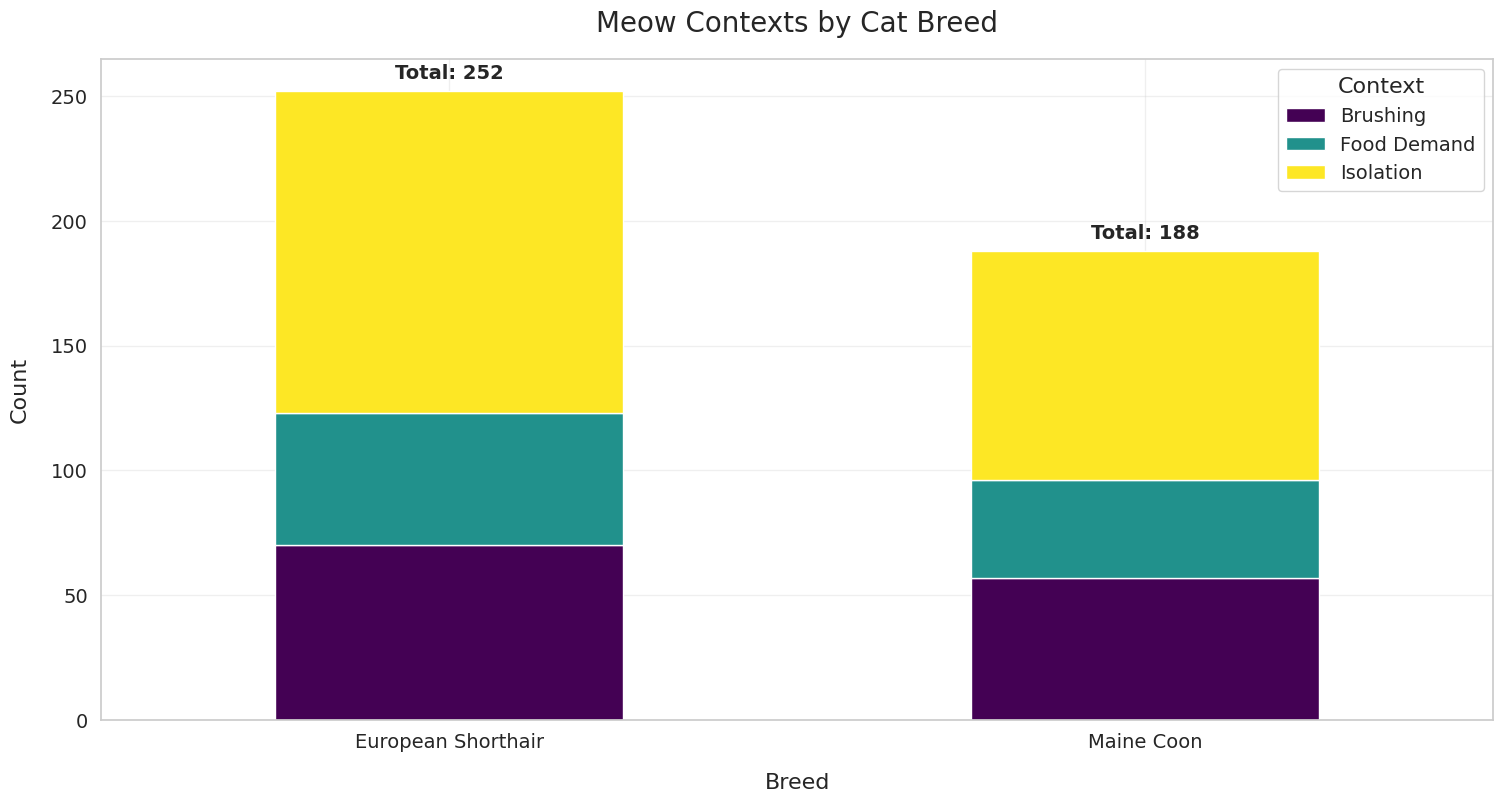

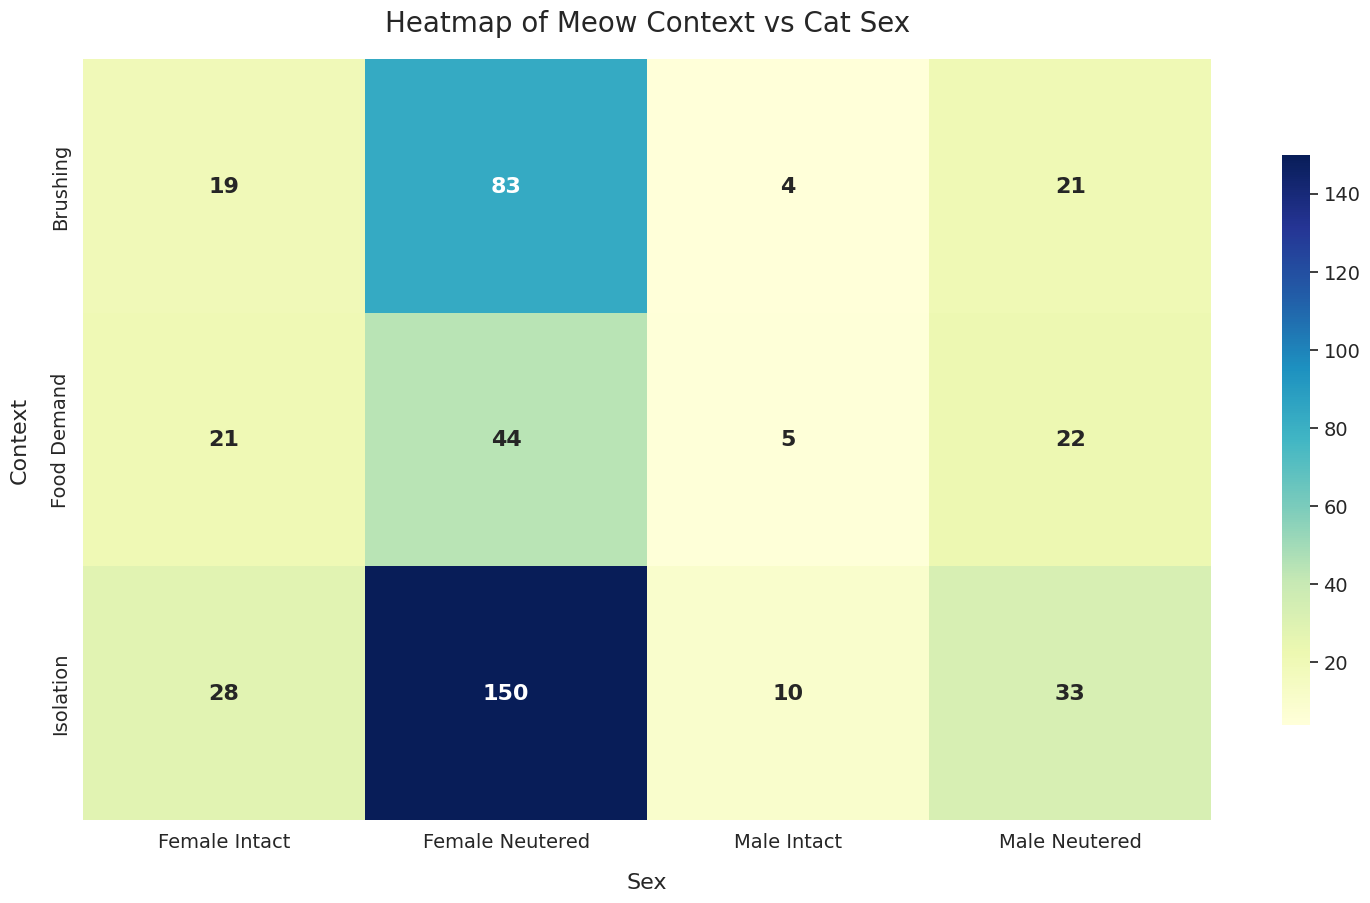

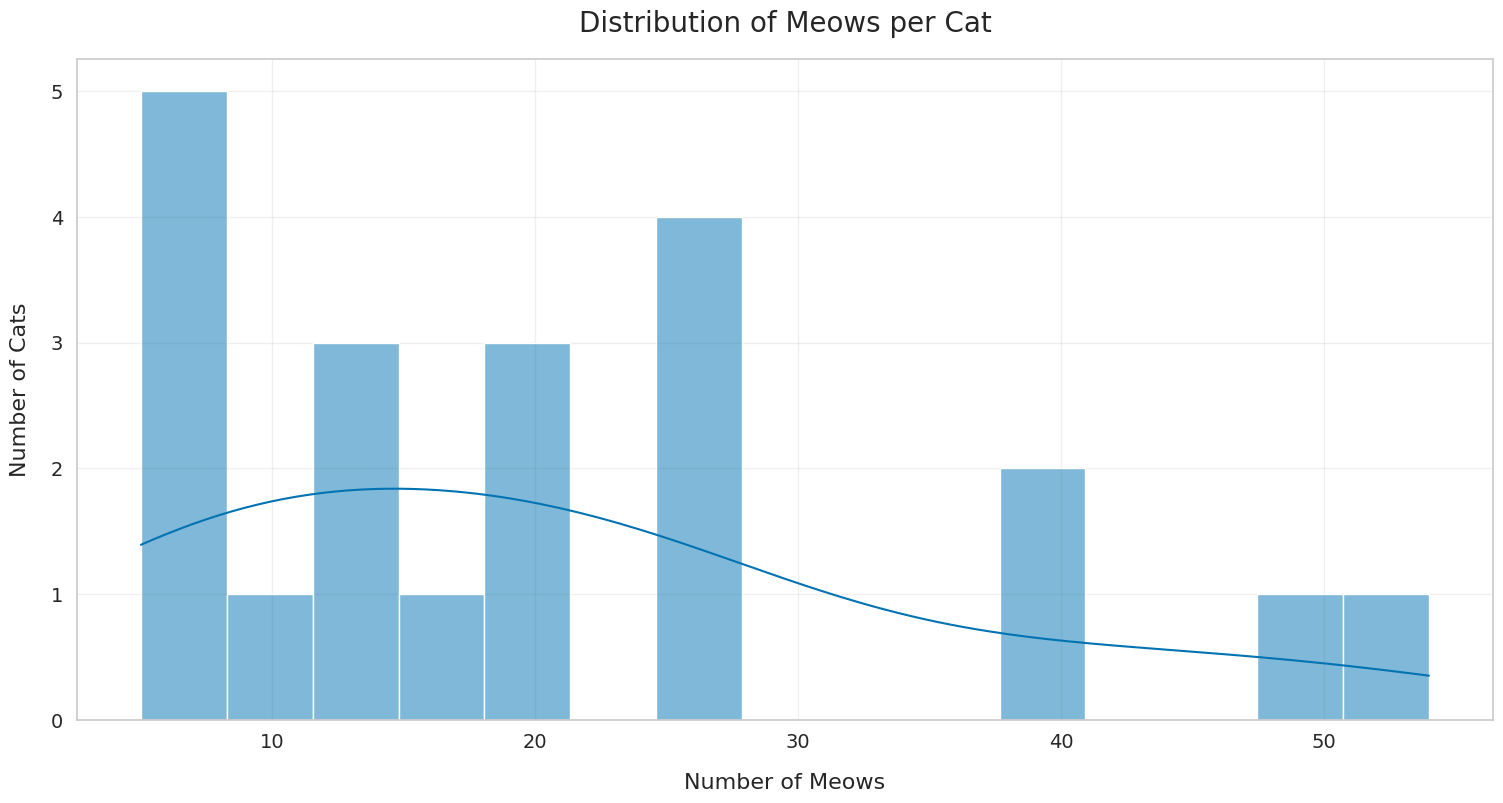


--- DATASET SUMMARY ---
Total meow samples: 440
Unique cats: 21

Context distribution:
  Isolation: 221 (50.2%)
  Brushing: 127 (28.9%)
  Food Demand: 92 (20.9%)

Breed distribution:
  European Shorthair: 252 (57.3%)
  Maine Coon: 188 (42.7%)

Sex distribution:
  Female Neutered: 277 (63.0%)
  Male Neutered: 76 (17.3%)
  Female Intact: 68 (15.5%)
  Male Intact: 19 (4.3%)
----------------------


In [46]:
# ------------------
# 3.5 DATASET VISUALIZATION (Cat Demographics)
# ------------------
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import re
import warnings

# Suppress all warnings - this is the simplest approach
warnings.filterwarnings('ignore')

# Suppress specific warning types
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

# Suppress informational messages
import contextlib
import io

# This function can be used to suppress print statements when needed
def suppress_stdout():
    return contextlib.redirect_stdout(io.StringIO())

# Define the robust parsing function
def parse_cat_filename_robust(filename):
    """Parses cat meow filenames with more flexibility"""
    # Extract the first character which represents the context
    context = filename[0] if filename and len(filename) > 0 else "Unknown"

    # Map context codes to full names
    context_map = {'B': 'Brushing', 'F': 'Food Demand', 'I': 'Isolation'}
    context_name = context_map.get(context, "Unknown")

    # Extract breed information (MC or EU) if available
    breed = "Unknown"
    if "_MC_" in filename:
        breed = "Maine Coon"
    elif "_EU_" in filename:
        breed = "European Shorthair"

    # Extract sex information if available
    sex = "Unknown"
    if "_MN_" in filename:
        sex = "Male Neutered"
    elif "_FN_" in filename:
        sex = "Female Neutered"
    elif "_MI_" in filename:
        sex = "Male Intact"
    elif "_FI_" in filename:
        sex = "Female Intact"

    # Try to extract cat ID - this is the code after the first underscore
    cat_id = "Unknown"
    parts = filename.split('_')
    if len(parts) > 1:
        cat_id = parts[1]

    return {
        'context': context_name,
        'breed': breed,
        'sex': sex,
        'cat_id': cat_id,
        'filename': filename
    }

def analyze_cat_dataset_robust(directory):
    """Analyze the cat meow dataset with more robust parsing"""
    cat_data = []

    # Check if we're looking in the right directory
    if not os.path.exists(directory):
        print(f"Warning: Directory {directory} does not exist.")
        # Try to find WAV files in subdirectories
        for root, dirs, files in os.walk("cat_meows"):
            for file in files:
                if file.endswith(".wav"):
                    try:
                        info = parse_cat_filename_robust(file)
                        info['path'] = os.path.join(root, file)
                        cat_data.append(info)
                    except Exception as e:
                        print(f"Could not parse filename {file}: {e}")
    else:
        # Look for files in the specified directory
        for file in os.listdir(directory):
            if file.endswith(".wav"):
                try:
                    info = parse_cat_filename_robust(file)
                    info['path'] = os.path.join(directory, file)
                    cat_data.append(info)
                except Exception as e:
                    print(f"Could not parse filename {file}: {e}")

    if not cat_data:
        print("Warning: No data could be parsed. Check directory path.")

    return pd.DataFrame(cat_data)

# Search for cat meow files
possible_dirs = [
    "cat_meows/dataset/dataset",
    "cat_meows/dataset",
    "cat_meows"
]

df_cats = None
for dir_path in possible_dirs:
    print(f"Trying directory: {dir_path}")
    # Suppress print output for directory searching
    with suppress_stdout():
        df = analyze_cat_dataset_robust(dir_path)
    if not df.empty:
        df_cats = df
        # Only print the final result
        print(f"✓ Found {len(df)} cat audio files in {dir_path}")
        break

if df_cats is None or df_cats.empty:
    # Last resort: search for WAV files recursively
    print("Searching for WAV files recursively...")
    df_cats = analyze_cat_dataset_robust("cat_meows")

# Now visualize the data if available
if df_cats is not None and not df_cats.empty:
    # Set consistent styling for better video presentation
    plt.rcParams.update({
        'font.size': 14,          # Larger base font size
        'axes.titlesize': 18,     # Larger title
        'axes.labelsize': 16,     # Larger axis labels
        'xtick.labelsize': 14,    # Larger tick labels
        'ytick.labelsize': 14,
        'figure.titlesize': 20,   # Very large figure titles
        'figure.figsize': (16, 9),# 16:9 aspect ratio for video
        'figure.dpi': 100,        # Higher DPI for clarity
        'savefig.dpi': 300,       # Higher save DPI
        'figure.facecolor': 'white',
        'axes.grid': True,
        'grid.alpha': 0.3
    })

    # Use a clean, high-contrast color palette
    sns.set_palette("colorblind")
    sns.set_style("whitegrid")

    # Create separate figures for each plot for better video presentation

    # 1. Context Distribution
    plt.figure(figsize=(16, 9))
    context_counts = df_cats['context'].value_counts()
    # Updated barplot syntax to avoid FutureWarning
    ax = sns.barplot(x=context_counts.index, y=context_counts.values, hue=context_counts.index, legend=False, palette="viridis")
    plt.title('Distribution of Meow Contexts', fontsize=20, pad=20)
    plt.xlabel('Context', fontsize=16, labelpad=15)
    plt.ylabel('Count', fontsize=16, labelpad=15)
    # Add count labels
    for i, v in enumerate(context_counts.values):
        ax.text(i, v + 5, str(v), ha='center', fontsize=16, fontweight='bold')
    plt.tight_layout(pad=3.0)
    plt.savefig('context_distribution.png')
    plt.show()

    # 2. Breed Distribution
    plt.figure(figsize=(16, 9))
    breed_counts = df_cats['breed'].value_counts()
    # Updated barplot syntax to avoid FutureWarning
    ax = sns.barplot(x=breed_counts.index, y=breed_counts.values, hue=breed_counts.index, legend=False, palette="Set2")
    plt.title('Distribution of Cat Breeds', fontsize=20, pad=20)
    plt.xlabel('Breed', fontsize=16, labelpad=15)
    plt.ylabel('Count', fontsize=16, labelpad=15)
    # Add count labels
    for i, v in enumerate(breed_counts.values):
        ax.text(i, v + 5, str(v), ha='center', fontsize=16, fontweight='bold')
    plt.tight_layout(pad=3.0)
    plt.savefig('breed_distribution.png')
    plt.show()

    # 3. Sex Distribution
    plt.figure(figsize=(16, 9))
    sex_counts = df_cats['sex'].value_counts()
    # Updated barplot syntax to avoid FutureWarning
    ax = sns.barplot(x=sex_counts.index, y=sex_counts.values, hue=sex_counts.index, legend=False, palette="Set3")
    plt.title('Distribution of Cat Sexes', fontsize=20, pad=20)
    plt.xlabel('Sex', fontsize=16, labelpad=15)
    plt.ylabel('Count', fontsize=16, labelpad=15)
    plt.xticks(rotation=25)  # Slight rotation for readability
    # Add count labels
    for i, v in enumerate(sex_counts.values):
        ax.text(i, v + 5, str(v), ha='center', fontsize=16, fontweight='bold')
    plt.tight_layout(pad=3.0)
    plt.savefig('sex_distribution.png')
    plt.show()

    # 4. Context by Breed (stacked bar chart)
    plt.figure(figsize=(16, 9))
    context_breed = pd.crosstab(df_cats['breed'], df_cats['context'])
    context_breed.plot(kind='bar', stacked=True, colormap='viridis',
                      figsize=(16, 9), rot=0)
    plt.title('Meow Contexts by Cat Breed', fontsize=20, pad=20)
    plt.xlabel('Breed', fontsize=16, labelpad=15)
    plt.ylabel('Count', fontsize=16, labelpad=15)
    plt.legend(title='Context', title_fontsize=16, fontsize=14, loc='upper right')
    # Add annotations for total counts
    for i, breed in enumerate(context_breed.index):
        total = context_breed.loc[breed].sum()
        plt.text(i, total + 5, f'Total: {total}', ha='center', fontsize=14, fontweight='bold')
    plt.tight_layout(pad=3.0)
    plt.savefig('context_by_breed.png')
    plt.show()

    # 5. Heatmap of Context vs Sex
    plt.figure(figsize=(16, 10))
    context_sex = pd.crosstab(df_cats['context'], df_cats['sex'])
    sns.heatmap(context_sex, annot=True, cmap="YlGnBu", fmt='d',
               annot_kws={"size": 16, "weight": "bold"}, cbar_kws={"shrink": 0.75})
    plt.title('Heatmap of Meow Context vs Cat Sex', fontsize=20, pad=20)
    plt.xlabel('Sex', fontsize=16, labelpad=15)
    plt.ylabel('Context', fontsize=16, labelpad=15)
    plt.tight_layout(pad=3.0)
    plt.savefig('context_sex_heatmap.png')
    plt.show()

    # 6. Distribution of meows per cat (as a histogram)
    plt.figure(figsize=(16, 9))
    meows_per_cat = df_cats['cat_id'].value_counts()
    sns.histplot(meows_per_cat.values, kde=True, bins=15)
    plt.title('Distribution of Meows per Cat', fontsize=20, pad=20)
    plt.xlabel('Number of Meows', fontsize=16, labelpad=15)
    plt.ylabel('Number of Cats', fontsize=16, labelpad=15)
    plt.tight_layout(pad=3.0)
    plt.savefig('meows_per_cat.png')
    plt.show()

    # Save summary to a text file for reference
    with open('cat_meow_summary.txt', 'w') as f:
        f.write("--- CAT MEOW DATASET SUMMARY ---\n\n")
        f.write(f"Total meow samples: {len(df_cats)}\n")
        f.write(f"Unique cats: {df_cats['cat_id'].nunique()}\n\n")

        f.write("Context distribution:\n")
        for context, count in context_counts.items():
            f.write(f"  {context}: {count} ({count/len(df_cats)*100:.1f}%)\n")

        f.write("\nBreed distribution:\n")
        for breed, count in breed_counts.items():
            f.write(f"  {breed}: {count} ({count/len(df_cats)*100:.1f}%)\n")

        f.write("\nSex distribution:\n")
        for sex, count in sex_counts.items():
            f.write(f"  {sex}: {count} ({count/len(df_cats)*100:.1f}%)\n")

    # Print summary statistics to notebook
    print("\n--- DATASET SUMMARY ---")
    print(f"Total meow samples: {len(df_cats)}")
    print(f"Unique cats: {df_cats['cat_id'].nunique()}")
    print("\nContext distribution:")
    for context, count in context_counts.items():
        print(f"  {context}: {count} ({count/len(df_cats)*100:.1f}%)")

    print("\nBreed distribution:")
    for breed, count in breed_counts.items():
        print(f"  {breed}: {count} ({count/len(df_cats)*100:.1f}%)")

    print("\nSex distribution:")
    for sex, count in sex_counts.items():
        print(f"  {sex}: {count} ({count/len(df_cats)*100:.1f}%)")
    print("----------------------")
else:
    print("Error: Could not find or parse any data files.")

Found 483 meow files

🐱 Sample 1: cat_meows/dataset/dataset/B_MAT01_EU_FN_RIT01_204.wav
  Listen to this meow:


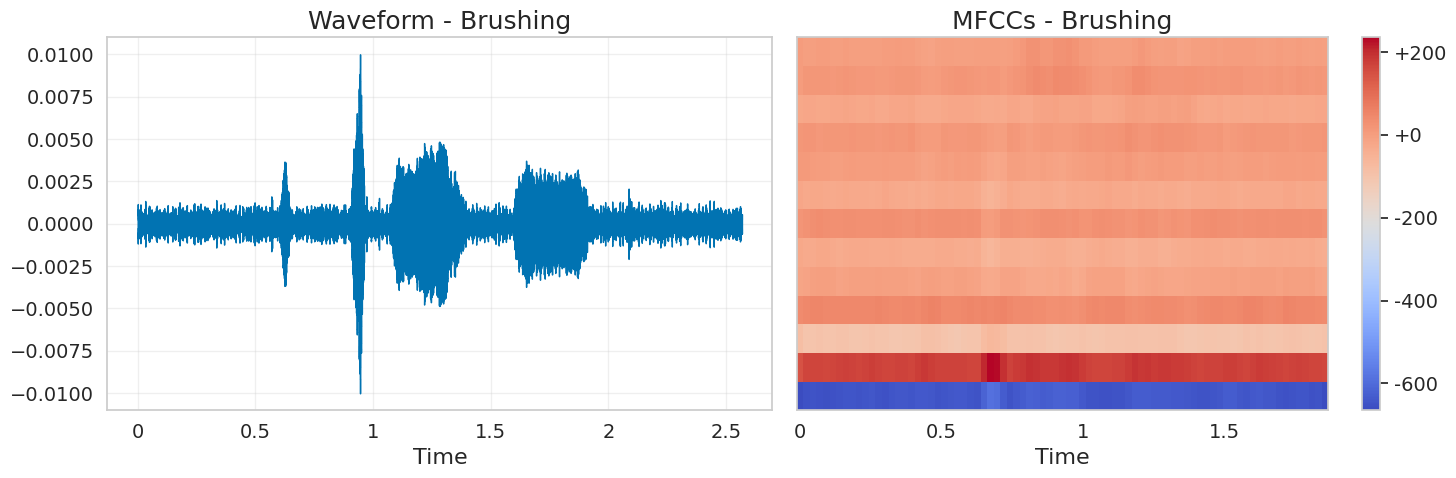


🐱 Sample 2: cat_meows/dataset/dataset/F_BLE01_EU_FN_DEL01_101.wav
  Listen to this meow:


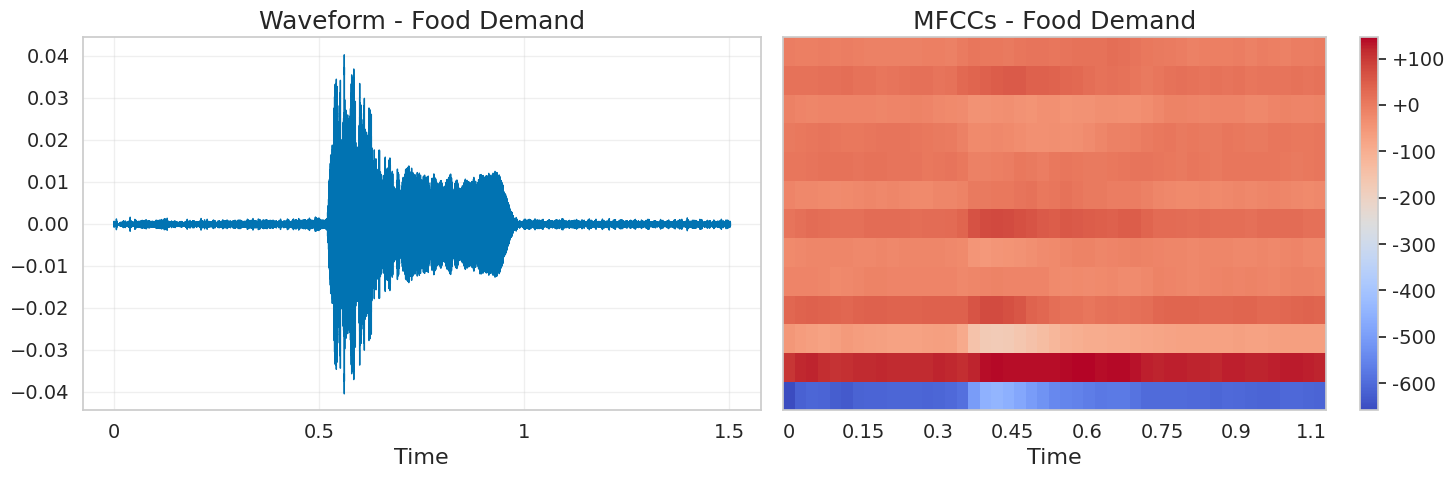


🐱 Sample 3: cat_meows/dataset/dataset/I_CAN01_EU_FN_GIA01_107.wav
  Listen to this meow:


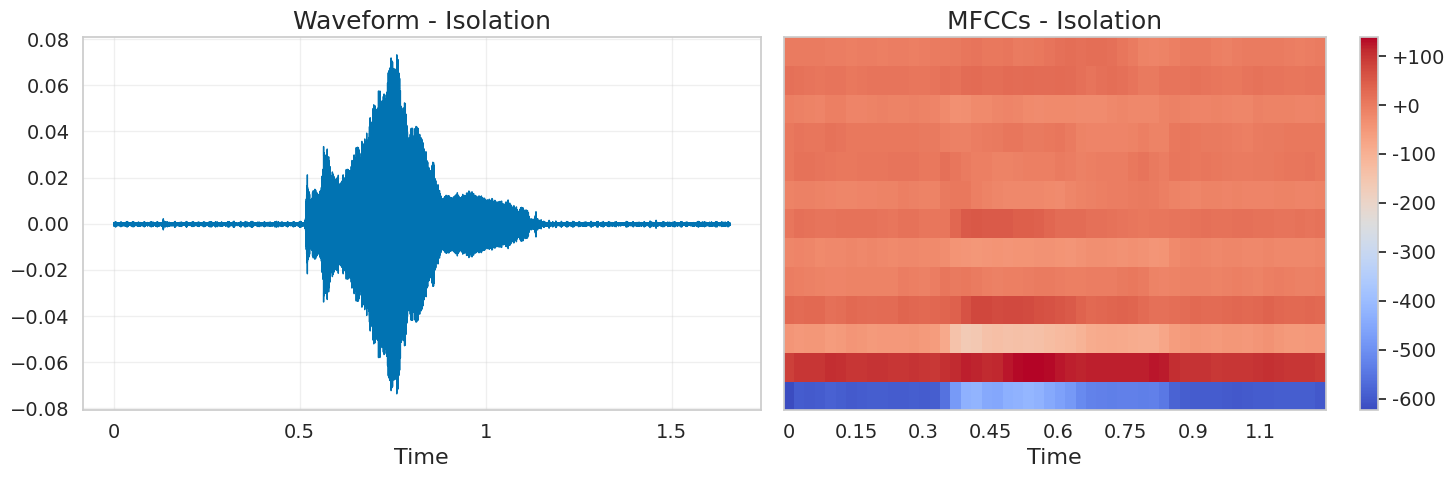


🐱 Sample 4: cat_meows/dataset/dataset/F_MEG01_MC_FI_SIM01_301.wav
  Listen to this meow:


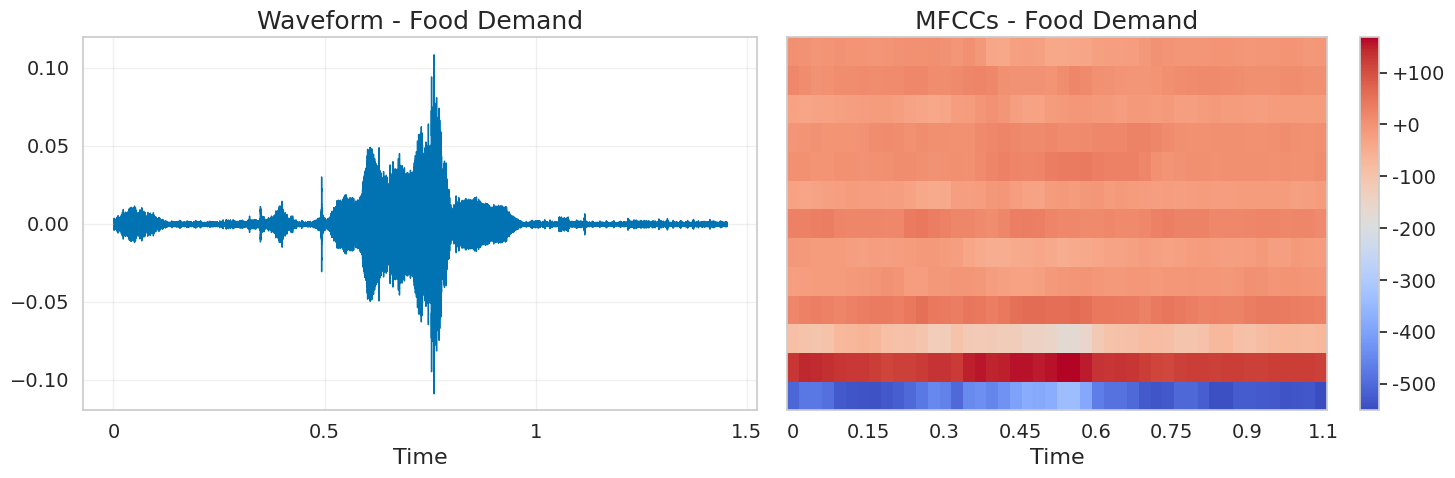


🐱 Sample 5: cat_meows/dataset/dataset/B_JJX01_MC_FN_SIM01_201.wav
  Listen to this meow:


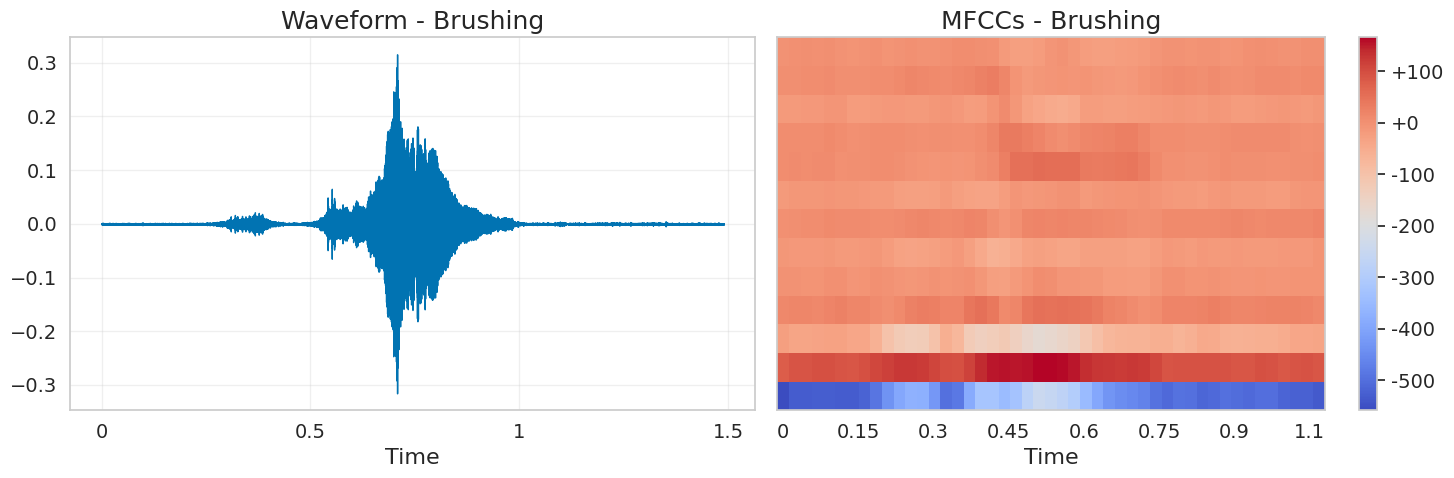

In [47]:
# ------------------
# 4. AUDIO PREPROCESSING (FIXED PATH)
# ------------------
def load_and_process(file_path):
    """Converts meows to machine-digestible format"""
    try:
        audio, sr = librosa.load(file_path, sr=16000)  # Downsample to 16kHz
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
        return mfccs.T, audio, sr
    except Exception as e:
        print(f"😿 Failed to process {file_path}: {str(e)}")
        return None, None, None

# Get WAV FILE paths
wav_files = []
for root, dirs, files in os.walk("cat_meows"):
    for file in files:
        if file.endswith(".wav"):
            wav_files.append(os.path.join(root, file))

print(f"Found {len(wav_files)} meow files")

# Select files from different contexts if possible (B, F, I prefixes)
context_samples = {}
for file_path in wav_files:
    file_name = os.path.basename(file_path)
    context = file_name[0]  # Get first letter of filename (B, F, or I)
    if context not in context_samples:
        context_samples[context] = file_path
    if len(context_samples) >= 3:  # One from each context
        break

# If we couldn't find all contexts, add random samples until we have 5
sample_files = list(context_samples.values())
while len(sample_files) < 5 and len(wav_files) >= 5:
    random_file = np.random.choice(wav_files)
    if random_file not in sample_files:
        sample_files.append(random_file)

# Import for audio display
from IPython.display import Audio, display

# Process each meow sample one by one with its audio player
for i, file_path in enumerate(sample_files[:5]):  # Limit to 5 samples
    mfccs, audio, sr = load_and_process(file_path)
    file_name = os.path.basename(file_path)
    context_type = file_name[0]
    context_name = {'B': 'Brushing', 'F': 'Food Demand', 'I': 'Isolation'}.get(context_type, 'Unknown')

    if mfccs is not None:
        # Display info about this meow
        try:
            info = parse_cat_filename(file_name)
            print(f"\n🐱 Sample {i+1}: {context_name} meow")
            print(f"  File: {file_name}")
            print(f"  Cat: {info['breed']} ({info['sex']}), Session: {info['session']}")
        except:
            print(f"\n🐱 Sample {i+1}: {file_path}")

        # Display audio player for this meow
        print(f"  Listen to this meow:")
        display(Audio(file_path))

        # Now create a figure with waveform and MFCC for this sample
        plt.figure(figsize=(15, 5))

        # Plot waveform
        plt.subplot(1, 2, 1)
        librosa.display.waveshow(audio, sr=sr)
        plt.title(f"Waveform - {context_name}")

        # Plot MFCCs
        plt.subplot(1, 2, 2)
        librosa.display.specshow(mfccs.T, x_axis='time')
        plt.colorbar(format='%+2.0f')
        plt.title(f"MFCCs - {context_name}")

        plt.tight_layout()
        plt.show()


In [48]:
# ------------------
# 5. BUILD DATASET (Cat food preparation)
# ------------------
X = []
y = []
context_map = {'B': 0, 'F': 1, 'I': 2}
reverse_map = {v:k for k,v in context_map.items()}

for file in os.listdir("cat_meows/dataset/dataset"):
    if file.endswith(".wav"):
        file_path = os.path.join("cat_meows/dataset/dataset", file)
        # Only append the MFCCs to X, not the entire tuple
        mfccs, _, _ = load_and_process(file_path)
        X.append(mfccs)
        y.append(context_map[file[0]])

# Pad sequences to same length
max_len = max([x.shape[0] for x in X])
X_padded = np.array([np.pad(x, ((0,max_len - x.shape[0]),(0,0))) for x in X])
y = np.array(y)

print(f"📊 Data shape: {X_padded.shape} | Meow contexts: {np.unique(y, return_counts=True)}")

📊 Data shape: (440, 126, 13) | Meow contexts: (array([0, 1, 2]), array([127,  92, 221]))


In [49]:
# ------------------
# 6. BUILD MODEL (Cat-alyst for translation)
# ------------------
model = models.Sequential([
    layers.Input(shape=(X_padded.shape[1], X_padded.shape[2])),
    layers.Conv1D(64, 3, activation='relu', padding='same'),
    layers.MaxPooling1D(2),
    layers.Conv1D(128, 3, activation='relu', padding='same'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print("🧠 Model architecture:")
model.summary()

🧠 Model architecture:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)                    │ (None, 126, 64)             │           2,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 63, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 63, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_2           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,715 (139.51 KB)

 Trainable params: 35,715 (139.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.3979 - loss: 7.5275 - val_accuracy: 0.5341 - val_loss: 3.3312
Epoch 2/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4548 - loss: 2.7273 - val_accuracy: 0.6364 - val_loss: 1.7064
Epoch 3/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5933 - loss: 1.8192 - val_accuracy: 0.2500 - val_loss: 1.5745
Epoch 4/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5098 - loss: 1.2331 - val_accuracy: 0.4205 - val_loss: 1.3733
Epoch 5/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5537 - loss: 0.8967 - val_accuracy: 0.6023 - val_loss: 0.8897
Epoch 6/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6781 - loss: 0.7550 - val_accuracy: 0.7045 - val_loss: 0.7882
Epoch 7/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6786 - loss: 0.7523 - val_accuracy: 0.6477 - val_loss: 0.8634
Epoch 8/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7006 - loss: 0.7457 - val_accuracy: 0.6818 - v

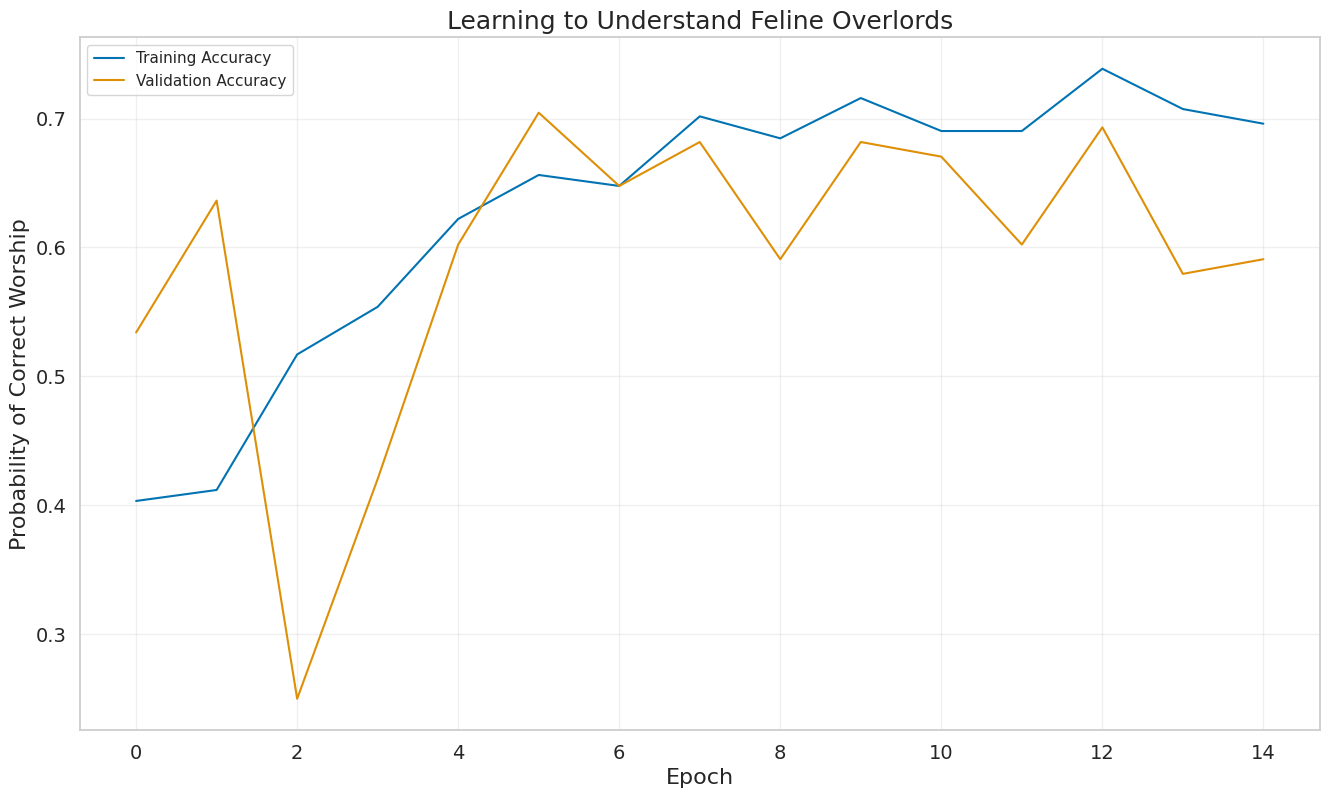

In [50]:
# ------------------
# 7. TRAIN (Teaching AI to serve cats)
# ------------------
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2)
history = model.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test))

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Learning to Understand Feline Overlords')
plt.ylabel('Probability of Correct Worship')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [51]:
# ------------------
# 8. TRANSLATION TIME! (Finally...)
# ------------------
class CatTranslator:
    def __init__(self, model, context_map):
        self.model = model
        self.reverse_map = reverse_map
        self.translations = {
            0: ["Human. You disturb my fur.", "The brush displeases me.", "This grooming is acceptable."],
            1: ["FOOD NOW.", "I smell tuna. Provide it.", "The bowl is EMPTY, peasant."],
            2: ["WHERE IS EVERYONE?!", "This place smells wrong.", "I demand cuddles immediately!"]
        }

    def translate(self, file_path):
        # Get only the MFCCs from load_and_process
        features, _, _ = load_and_process(file_path) # <--- Change is here
        padded = np.pad(features, ((0,max_len - features.shape[0]),(0,0)))
        pred = model.predict(padded[np.newaxis, ...])
        context = self.reverse_map[np.argmax(pred)]
        return np.random.choice(self.translations[np.argmax(pred)])

translator = CatTranslator(model, context_map)

In [52]:
# ------------------
# 9. DEMO (Behold, human!)
# ------------------
test_meow = "cat_meows/dataset/dataset/" + np.random.choice(os.listdir("cat_meows/dataset/dataset/"))
from IPython.display import Audio, display
display(Audio(test_meow))
print(f"🔊 Playing: {test_meow}")
print(f"🤖 AI Translation: {translator.translate(test_meow)}")

# Optional: Add audio playback
# from IPython.display import Audio
# Audio(test_meow)

# ------------------
# BONUS: Shakespearean Cat Mode
# ------------------
# (Requires OpenAI API key)
from openai import OpenAI
client = OpenAI()

def dramatic_translation(text):
    import openai
    response = client.chat.completions.create(
        model="gpt-4",
        messages=[{
            "role": "user",
            "content": f"Translate this cat demand into Shakespearean English: {text}"
        }]
    )
    return response.choices[0].message.content

print("\n🎭 Bard-worthy Translation:", dramatic_translation(translator.translate(test_meow)))

🔊 Playing: cat_meows/dataset/dataset/I_CLE01_EU_FN_FER01_101.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
🤖 AI Translation: I smell tuna. Provide it.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step

🎭 Bard-worthy Translation: Mine nose doth detect tuna. Pray, furnish it.


In [54]:
# ------------------
# 10. SAVE MODEL (Observe, peasant!)
# ------------------

model.save('cat_meow_model.keras')
print("💾 Model saved as cat_meow_model.keras")

💾 Model saved as cat_meow_model.keras


In [55]:
!jupyter nbconvert --to html /content/CatsMeow.ipynb


[NbConvertApp] Converting notebook /content/CatsMeow.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 12 image(s).
[NbConvertApp] Writing 1467934 bytes to /content/CatsMeow.html


In [56]:
!pip install nbconvert
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!jupyter nbconvert --to pdf /content/CatsMeow.ipynb

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  fonts-urw-base35 libapache-pom-java libcmark-gfm-extensions0.29.0.gfm.3 libcmark-gfm0.29.0.gfm.3
  libcommons-logging-java libcommons-parent-java libfontbox-java libfontenc1 libgs9 libgs9-common
  libidn12 libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0 libsynctex2
  libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lmodern pandoc-data poppler-data
  preview-latex-style rake ruby ruby-net-telnet ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0
  rubygems-integration t1utils teckit tex-common tex-gyre texlive-base texlive-binaries
  texlive-fonts-recommended texlive-latex-base texlive-latex-recommended texlive-pictures
  texlive-plain-generic tipa xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-fre